# Practical 3: Digital Elevation Models

In this practical, we'll make visualizations and calculate derived quantities of lidar DEMs of the Kīlauea volcano on the Big Island of Hawai'i. The DEMs cover the main volcano summit and the Halemau'mau crater from before and after the [2018 lower East Rift zone eruption](https://www.usgs.gov/volcanoes/kilauea/2018-lower-east-rift-zone-eruption-and-summit-collapse).

<figure>
    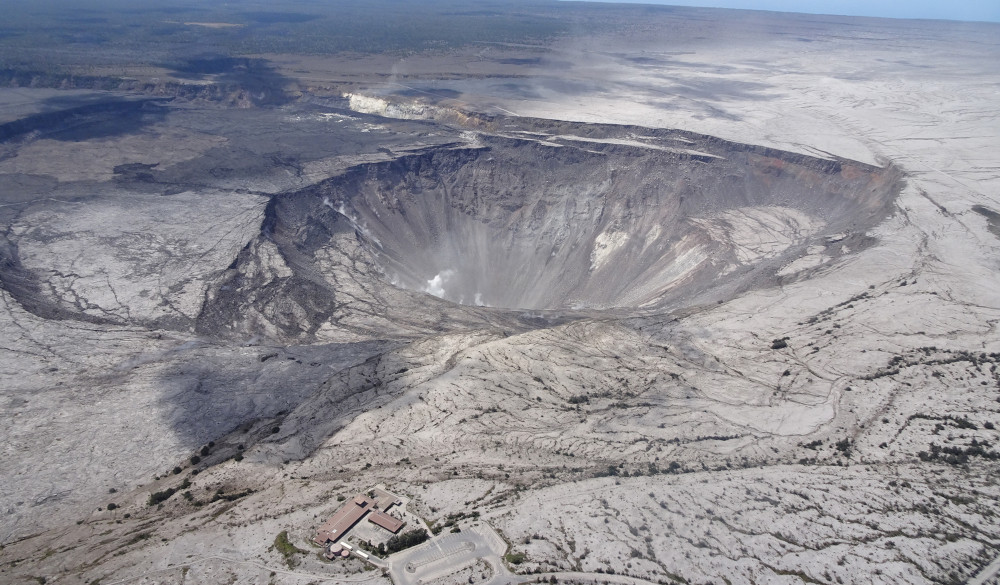
    <figcaption>
        Aerial photo of Halemau‘mau crater and part of the Kīlauea caldera taken on July 13, 2018. The buildings housed the USGS Hawaiian Volcano Observatory and Hawai‘i Volcanoes National Park's Jaggar Museum. 
        Source: <a href="https://www.usgs.gov/media/images/aerial-view-k-lauea-summit-july-13-2018">USGS (public domain)</a>.
    </figcaption>
</figure>


> 💡 **Tip:** To include an image on a Markdown cell, drag and drop it into one (in editor mode). That should generate Markdown that looks like `![Alt text](attachment:982holuch02ou2ncp2ch2ch2oc2c92.jpg)`. For a fancier version, look at the code for this cell which uses the `<figure>` HTML tag to add a caption to the image. 

----

## Import the required libraries

We'll start by importing the things we'll need to load the DEMs, do some calculations, and plot them.

> 💡 **Tip:** It's a good idea to put all your imports at the very first code cell of your notebook. This way you can easily check what needs to be installed for your notebook to work.

In [1]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
# Used for hillshading the DEM
import matplotlib.colors
# This is new. We'll use it do insert a Google Maps into the notebook.
import IPython.display

----

## Data

In this practical, we'll use 2 lidar DEMs of the Kīlauea volcano crater from 2009 and 2018. Both are available as TIFF files:

* Download [`kilauea.zip`](https://github.com/leouieda/remote-sensing/releases/download/2020%2F21/kilauea.zip)
* Unzip the archive in the `same folder as this notebook`.
* You should now have a `kilauea` folder with two `.tif` files with the DEMs:
    * `kilauea2009.tif` (source: [Hawaii Big Island Survey](https://doi.org/10.5069/G9DZ067X))
    * `kilauea2018.tif` (source: [Kilauea Volcano, HI July 2018 Acquisition](https://doi.org/10.5069/G9M32SV1))
* Both DEMs were generated with **2 meter** grid node spacing and covering the same area (they share the Southwest corner coordinates). 
* The value `-9999` indicates missing data and needs to be converted to Not-a-Number (NaN) values (see [`numpy.nan`](https://numpy.org/doc/stable/reference/constants.html?highlight=nan#numpy.nan)).

First, let's have a look at Google Maps to get a sense of scale and where this is in the world:

In [2]:
IPython.display.IFrame(width="100%", height=500, src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d949306.8317929382!2d-155.5989134839826!3d19.620110988369202!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x7953da07f03b8f35%3A0xd5195bd3c144082a!2sHalemaumau%20Crater!5e1!3m2!1sen!2suk!4v1644300567208!5m2!1sen!2suk")

Now, let's load the DEMs from the TIFF files using scikit-image:

In [3]:
kilauea2009 = skimage.io.imread("kilauea/kilauea2009.tif")
kilauea2018 = skimage.io.imread("kilauea/kilauea2018.tif")

In [4]:
kilauea2009

array([[-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ],
       ...,
       [ 1147.85,  1147.94,  1147.99, ..., -9999.  , -9999.  , -9999.  ],
       [ 1147.87,  1147.88,  1147.99, ..., -9999.  , -9999.  , -9999.  ],
       [-9999.  , -9999.  , -9999.  , ..., -9999.  , -9999.  , -9999.  ]],
      dtype=float32)

Notice that the data are already in `float32` (meters above the geoid/sea-level) and don't need to be converted from a digitized format to heights. **This may not be the case for every DEM you get**.

Now, we need to turn those `-9999` to "Not-a-Number" (`nan`) values. Otherwise, performing calculations on the DEM will be biased by those values. For numpy, many calculations ignore the `nan` values or have `nan`-aware variants (like `numpy.nanmean`).

We first need find all positions of the DEM that has the -9999 value. We can do this by the magic of numpy and comparison operators like `==`:

In [5]:
is_missing_2009 = kilauea2009 == -9999
is_missing_2009

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

By using a comparison operator on a numpy array, we get back another array that has `True` or `False` (known as **boolean values**) depending on the result of the comparison.

We can use this array to select all the position of a numpy array where the value is `True` (called **boolean indexing** in numpy terms) and set the value we want them to have:

In [6]:
kilauea2009[is_missing_2009] = np.nan
kilauea2009

array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       ...,
       [1147.85, 1147.94, 1147.99, ...,     nan,     nan,     nan],
       [1147.87, 1147.88, 1147.99, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
      dtype=float32)

We can now repeat this for the 2018 data:

In [7]:
is_missing_2018 = kilauea2018 == -9999
kilauea2018[is_missing_2018] = np.nan
kilauea2018

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ..., 1138.14  , 1138.45  ,
              nan],
       [      nan,       nan,       nan, ..., 1138.4299, 1138.2899,
              nan],
       ...,
       [1124.65  , 1124.75  , 1124.64  , ...,       nan,       nan,
              nan],
       [1124.69  , 1124.65  , 1124.77  , ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

### 🧘 Your turn

Make pseudo-color maps of both DEMs (including a colorbar). Choose an [appropriate colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for these plots. 

> 🧙 **Hint:** It helps with comparisons to ensure that the **maximum and minimum values of the colorbar are the same for both plots**. You can do this by setting the `vmin` and `vmax` parameters of `plt.imshow`.

> 🧙 **Hint:** To get the minimum and maximum values of arrays with `nan` in them, use `numpy.nanmin` and `numpy.nanmax`.

In [8]:
# Get the minimum and maximum values across both DEMs
minimum_height = min([np.nanmin(kilauea2009), np.nanmin(kilauea2018)])
maximum_height = min([np.nanmax(kilauea2009), np.nanmax(kilauea2018)])

Text(0.5, 1.0, 'DEM 2009')

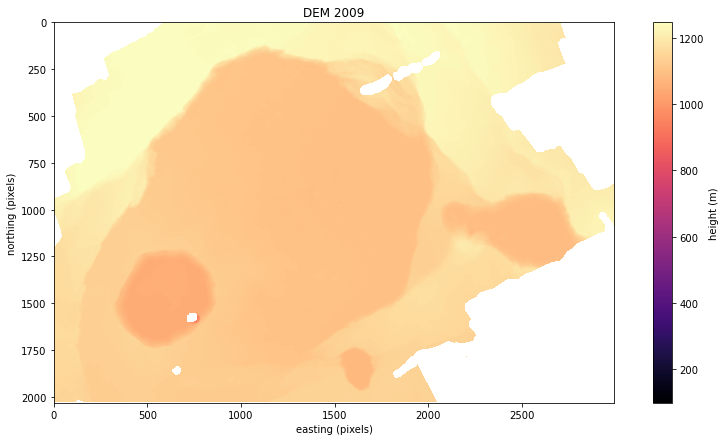

In [9]:
plt.figure(figsize=(14, 7))
plt.imshow(kilauea2009, cmap="magma", vmin=minimum_height, vmax=maximum_height)
plt.colorbar(label="height (m)")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")
plt.title("DEM 2009")

Text(0.5, 1.0, 'DEM 2018')

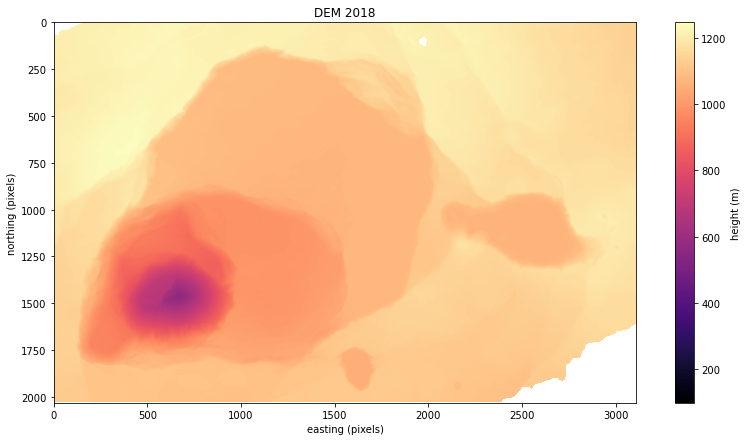

In [10]:
plt.figure(figsize=(14, 7))
plt.imshow(kilauea2018, cmap="magma", vmin=minimum_height, vmax=maximum_height)
plt.colorbar(label="height (m)")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")
plt.title("DEM 2018")

----

## Profiles

It can be helpful for visualization to extract profiles across features of the DEMs. This reduces the dimensions of the DEMs and allows for easier comparison of different datasets (both DEMs can be visualized in the same plot).

For simplicity, we'll extract East-West profiles across the Halemau'mau crater to visualize the summit collapse. We can do this by slicing and indexing the numpy arrays. 

> 💡 **Tip:** Extracting profiles along arbitrary lines is a bit more complicated and involves interpolation of the data. In Python, it can be done with the [Verde](https://www.fatiando.org/verde/latest/) library.

To get the main part of the crater, we'll set our East-West profile long pixel 1500 in the North-South direction.

In [11]:
profile2009 = kilauea2009[1500, :]
profile2009

array([1161.5 , 1161.47, 1161.49, ...,     nan,     nan,     nan],
      dtype=float32)

As an aid, we can calculate an array that has the distance along the profile by remembering that our grid was generated with **2 meter spacing**. We first make an array from 0 to the maximum number of points in the profile, then multiply by the spacing.

In [12]:
distance_profile2009 = np.arange(0, profile2009.size) * 2  # 2 meter spacing
distance_profile2009

array([   0,    2,    4, ..., 5980, 5982, 5984])

Plot this profile with matplotlib to see what it looks like.

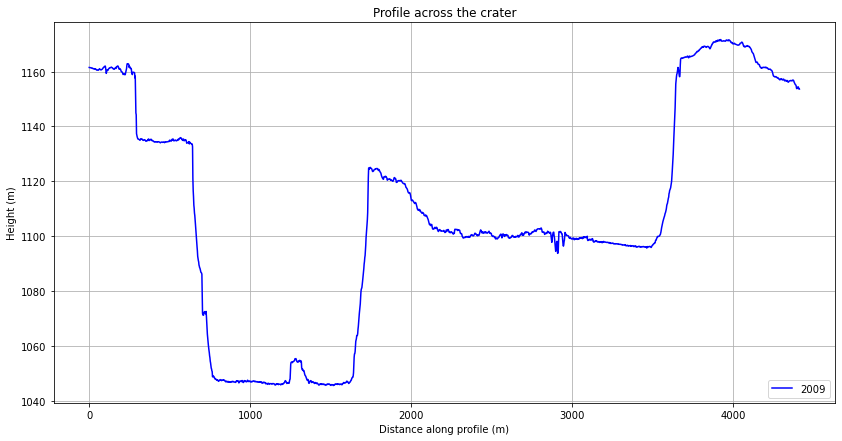

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(distance_profile2009, profile2009, "-b", label="2009")
plt.legend(loc="lower right")
plt.xlabel("Distance along profile (m)")
plt.ylabel("Height (m)")
plt.title("Profile across the crater")
plt.grid()

### 🧘 Your turn

Extract the same profile across the 2018 DEM and plot both together in the same figure for comparison.

> 🧙 **Hint:** The distance along the profile will not be the same since both DEMs have different dimensions (check their `.shape`) even though the grid spacing is the same and their Southwest corner coordinates are the same.

In [14]:
profile2018 = kilauea2018[1500, :]
profile2018

array([1138.0399, 1138.02  , 1137.98  , ..., 1167.1   , 1167.19  ,
             nan], dtype=float32)

In [15]:
distance_profile2018 = np.arange(0, profile2018.size) * 2
distance_profile2018

array([   0,    2,    4, ..., 6216, 6218, 6220])

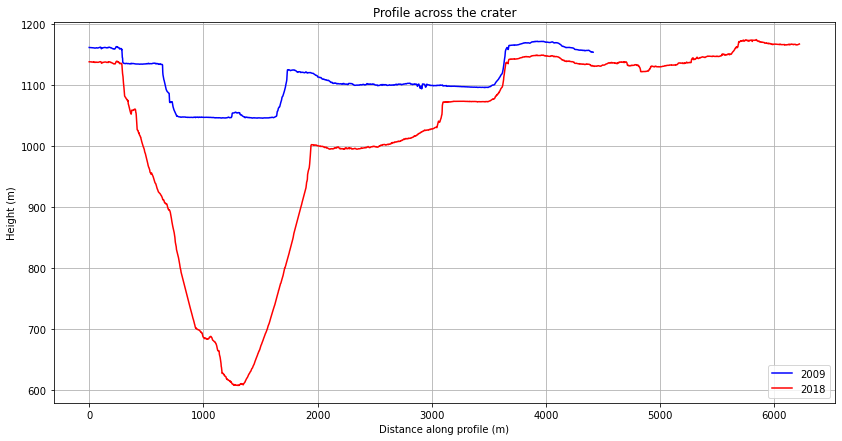

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(distance_profile2009, profile2009, "-b", label="2009")
plt.plot(distance_profile2018, profile2018, "-r", label="2018")
plt.legend(loc="lower right")
plt.xlabel("Distance along profile (m)")
plt.ylabel("Height (m)")
plt.title("Profile across the crater")
plt.grid()

----

## Spatial and volumetric analysis

Having co-registered DEMs from before and after the summit collapse allows us to calculate the difference between the two topographic surfaces. But before we can do so, we need to make both DEMs have the **exact same shape** (otherwise numpy won't let us calculate their differences). Since the 2018 DEM has a larger extent to the East and we know that both DEMs share the coordinates for their Southwestern corner, we can crop the North and East borders of the 2018 DEM.

In [17]:
rows2009, cols2009 = kilauea2009.shape
kilauea2018_crop = kilauea2018[0:rows2009, 0:cols2009]
print("Shape of 2018 DEM:", kilauea2018_crop.shape)
print("Shape of 2009 DEM:", kilauea2009.shape)

Shape of 2018 DEM: (2032, 2993)
Shape of 2009 DEM: (2032, 2993)


Now we can calculate the difference to see how much the crater collapsed.

In [18]:
kilauea_difference = kilauea2009 - kilauea2018_crop
kilauea_difference

array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [23.199951, 23.189941, 23.349976, ...,       nan,       nan,
              nan],
       [23.180054, 23.22998 , 23.21997 , ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

And plot the results.

Text(0.5, 1.0, 'Difference between 2009 and 2018')

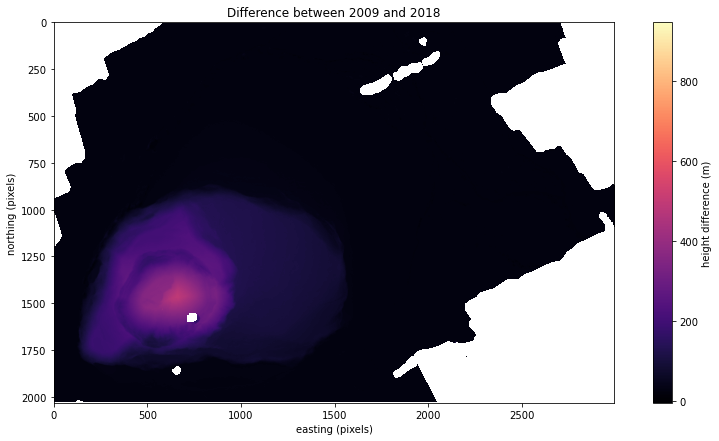

In [19]:
plt.figure(figsize=(14, 7))
plt.imshow(kilauea_difference, cmap="magma")
plt.colorbar(label="height difference (m)")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")
plt.title("Difference between 2009 and 2018")

### 🧘 Your turn

Estimate the **total volume change** in the crater that resulted from the summit collapse. Compare your estimate with the [official USGS numbers](https://volcanoes.usgs.gov/vsc/file_mngr/file-192/PrelimSum_LERZ-Summit_2018.pdf). Consider and discuss the sources of uncertainty in your estimate.

> 🧙 **Hint:** Adding, subtracting, multiplying, and dividing `nan` values with any number results in a `nan` value. To safely work with data containing NaNs, use the `nan` version of numpy functions, like `np.nanmax`, `np.nanmean`, `np.nansum`, etc. 

In [20]:
pixel_area = 2 ** 2  # 2 x 2 m² since the grid spacing is 2 m

The volume change will be the sum of the volume of each pixel in the difference array:

$$
V = \sum\limits_{i=1}^{N} h_i A = A \sum\limits_{i=1}^{N} h_i
$$

in which $A$ is the area of the pixel, $h_i$ is the height difference of the $i\text{-th}$ pixel, and $N$ is the number of pixels in the image.

We know that the pixel area is the grid spacing squared so all we need to do now is calculate the sum of the elements in the height difference array. We can do this with `np.nansum`.

In [21]:
volume_change = np.nansum(kilauea_difference) * pixel_area
print("Total volume change:", volume_change, "m³")

Total volume change: 1044317952.0 m³


That's a bit more than the official ~840 million m³ reported by the USGS but their numbers consider only the inner caldera whereas we're calculating for the entire DEM. So it's not surprising that we get a larger number (but still roughly compatible).

----

## Hillshading

Pseudo-color plots of DEMs can be a bit tricky to visualize things like slope change and subtle differences in height and terrain roughness. Hillshading aims to aid the visualization of these datasets. It works by adding artificial light and shade to a raster dataset (a grid). It can help visualize subtle changes in data values and produce more realistic looking topographic pseudo-color maps.  

> ⚠️ **WARNING:** Hillshading can also cause **optical illusions and over-emphasize features in the data**. Watch this [Minute Physics video explaning the optical illusion](https://www.youtube.com/watch?v=V7C318DGB38) to find out more. 


Matplotlib has capabilities for doing this with the `matplotlib.colors.LightSource` class. First thing we need to is create a light source for our hillshading.

In [22]:
light = matplotlib.colors.LightSource(azdeg=340, altdeg=60)

The `azdeg` and `altdeg` control the direction of the light source (the artificial Sun) and stand for "azimuth in degrees" and "altitude in degrees".

> 💡 **Tip:** See [this example in the matplotlib gallery](https://matplotlib.org/stable/gallery/specialty_plots/topographic_hillshading.html#sphx-glr-gallery-specialty-plots-topographic-hillshading-py) to explore all of the options available for using the light source.

Now we can apply hillshading to one of our DEMs and plot it.

In [23]:
kilauea2009_shaded = light.hillshade(kilauea2009, vert_exag=3, dx=2, dy=2)  # dx and dy are the grid spacing in x and y

Text(0.5, 1.0, 'DEM 2009')

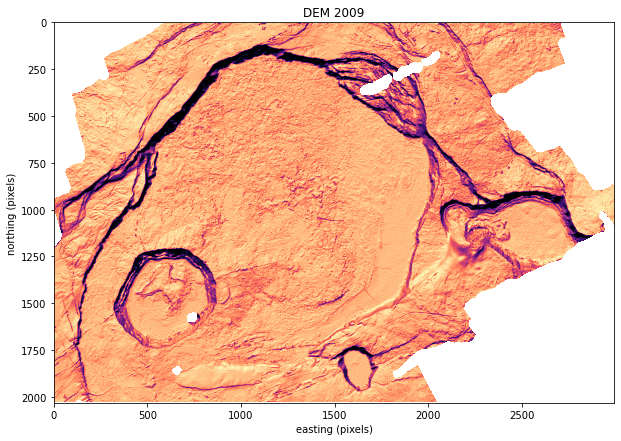

In [24]:
plt.figure(figsize=(14, 7))
plt.imshow(kilauea2009_shaded, cmap="magma")
plt.xlabel("easting (pixels)")
plt.ylabel("northing (pixels)")
plt.title("DEM 2009")

**Does hillshading aid in your interpretation of this DEM?** If so, how? Are there any features you can see clearly in the hillshaded version that were di

> ⚠️ **WARNING:** Hillshading makes the **colormap meaningless** since the shadows and light change the mapping of colors to data values. The color values can no longer be interpreted as height changes.

### 🧘 Your turn

Make different hillshaded maps by varying:

* The azimuth and altitude of the light source
* The vertical exaggeration applied

> 🧙 **Hint:**  Use one or more `for` loops to generate many figures in a single step.

How do these parameters affect your perception of the relief? What lessons about the use of hillshading can you draw from this experiment?

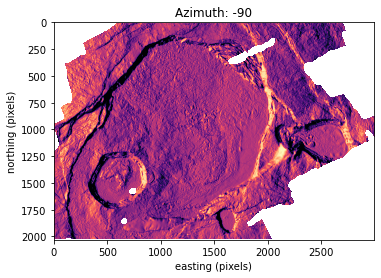

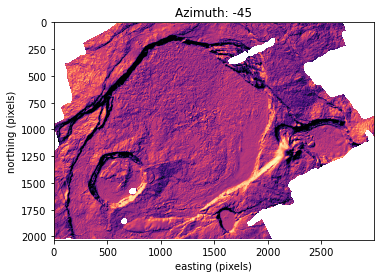

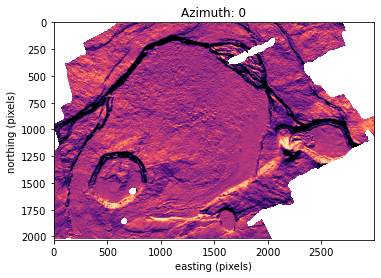

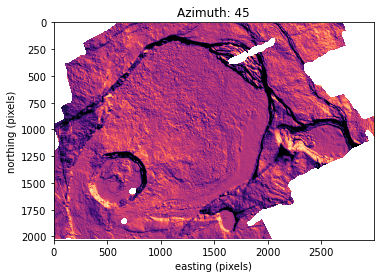

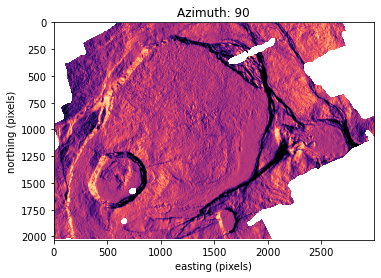

In [25]:
azimuth_list = [-90, -45, 0, 45, 90]
for azimuth in azimuth_list:
    light = matplotlib.colors.LightSource(azdeg=azimuth, altdeg=30)
    plt.figure()
    plt.imshow(light.hillshade(kilauea2009, vert_exag=5, dx=2, dy=2), cmap="magma")
    plt.xlabel("easting (pixels)")
    plt.ylabel("northing (pixels)")
    plt.title(f"Azimuth: {azimuth}")

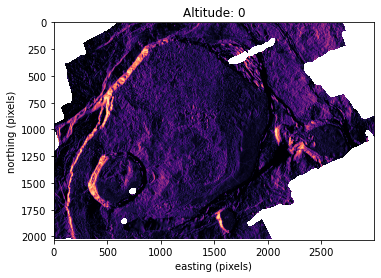

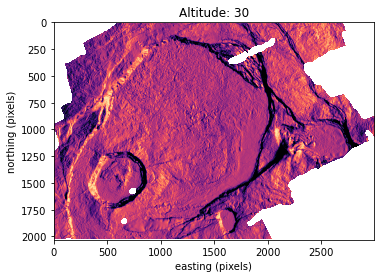

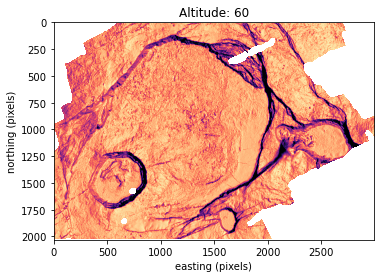

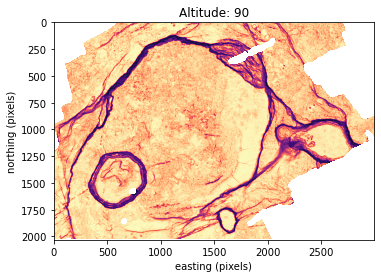

In [26]:
altitude_list = [0, 30, 60, 90]
for altitude in altitude_list:
    light = matplotlib.colors.LightSource(azdeg=90, altdeg=altitude)
    plt.figure()
    plt.imshow(light.hillshade(kilauea2009, vert_exag=5, dx=2, dy=2), cmap="magma")
    plt.xlabel("easting (pixels)")
    plt.ylabel("northing (pixels)")
    plt.title(f"Altitude: {altitude}")

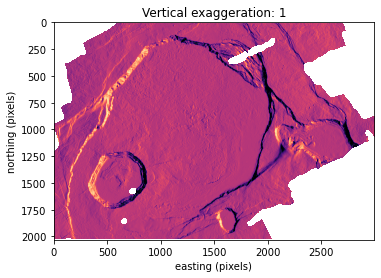

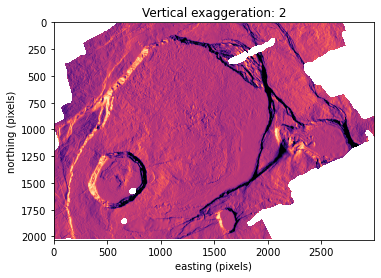

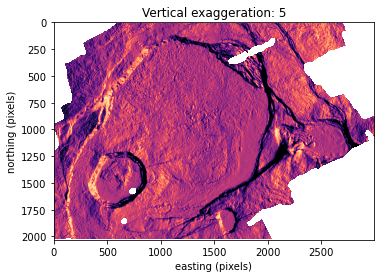

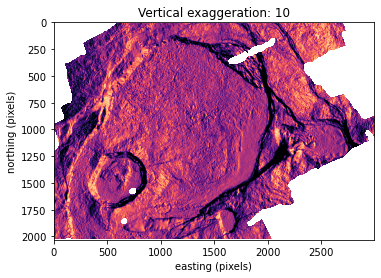

In [27]:
exaggeration_list = [1, 2, 5, 10]
for exaggeration in exaggeration_list:
    light = matplotlib.colors.LightSource(azdeg=90, altdeg=30)
    plt.figure()
    plt.imshow(light.hillshade(kilauea2009, vert_exag=exaggeration, dx=2, dy=2), cmap="magma")
    plt.xlabel("easting (pixels)")
    plt.ylabel("northing (pixels)")
    plt.title(f"Vertical exaggeration: {exaggeration}")